# Import Required Packages

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, ConcatDataset
from torch.distributions import Normal, kl_divergence
from torch.nn.functional import one_hot
from torchvision import transforms
import matplotlib.pyplot as plt

# Load Dataset

In [ ]:
transforms_ = transforms.Compose([
    transforms.Resize([14,14]),
    transforms.ToTensor()
])

train_set = datasets.MNIST( download=True,  root="./",  transform=transforms_ ,train=True)
test_set = datasets.MNIST(download=True, root="./", transform=transforms_, train=False)
full_set = ConcatDataset([train_set, test_set])
train_loader = DataLoader(full_set, batch_size=2048, shuffle=False)

# Define Model, Loss And Optimizer

In [3]:
class VarietionalAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.down_layer = nn.Sequential(
            nn.Linear(196 + 10, 256),
            nn.LeakyReLU(0.2, True),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, True),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128)
        )
        self.up_layer = nn.Sequential(
            nn.Linear(64 + 10, 128),
            nn.LeakyReLU(0.2, True),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2, True),
            nn.Linear(256, 196)
        )
        
    def forward(self, image, label):
        image_with_one_hot = torch.concatenate([image.view(-1, 196), one_hot(label)], dim=1)
        o = self.down_layer(image_with_one_hot)
        mu = o[:, :64]
        sigma = o[:, 64:]
        std = sigma.exp_()
        eps = Variable(torch.FloatTensor(std.size()).normal_().to(image.device))
        noise = eps.mul(std).add_(mu)
        noise_with_one_hot = torch.concatenate([noise, one_hot(label)], dim=1)
        return self.up_layer(noise_with_one_hot).view(-1, 1, 14, 14), noise, mu, std
    
    def generate(self, label):
        noise = torch.randn(label.shape[0], 64).to(label.device)
        noise_with_one_hot = torch.concatenate([noise, one_hot(label, 10)], dim=1)
        return self.up_layer(noise_with_one_hot).view(-1, 14, 14)
    

device = 'cuda' if torch.cuda.is_available() else 'cpu'
vae = VarietionalAutoEncoder().to(device)
vae.load_state_dict(torch.load('vae.pth', 'cuda', weights_only=True))
criterion = nn.L1Loss()
optimizer = optim.Adam(vae.parameters(), lr=1e-2)

# Train Model

In [ ]:
import numpy as np
import torch
from torch.distributions import Normal, kl_divergence

def compute_kl_divergence(mu, sigma):
    output_distribution = Normal(mu, sigma)
    standard_normal_distribution = Normal(torch.zeros_like(mu), torch.ones_like(sigma))
    kl_loss = kl_divergence(output_distribution, standard_normal_distribution)
    return kl_loss.mean().abs()

for epoch in range(30):        
    l1_loss = []
    kld_loss = []
    total_loss = []
    for i, (data, label) in enumerate(data):
        data = data.to(device)
        label = label.to(device)
        image, noise, mu, std = vae(data, label)
        l1 = criterion(data, image)
        kld = compute_kl_divergence(mu, std)
        loss = 0.9 * l1 + 0.1 * kld
        l1_loss.append(l1.item())
        kld_loss.append(kld.item())
        total_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'epoch {epoch+1}      l1 {np.mean(l1_loss)}      kld {np.mean(kld_loss)}      total {np.mean(total_loss)}')
        

# Generate Results

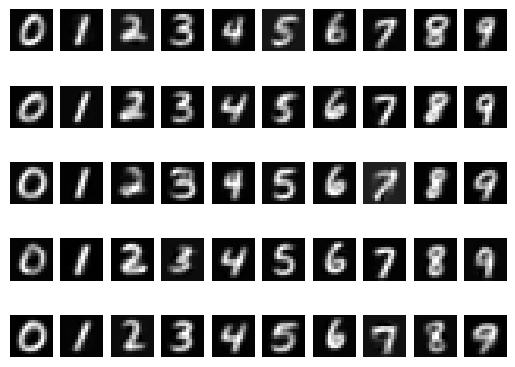

In [4]:
labels = torch.concatenate([torch.linspace(0, 9, 10).type(torch.LongTensor) for _ in range(5)]).to(device)
images = vae.generate(labels)

plt.figure()
for i in range(50):
    plt.subplot(5, 10, i+1)
    plt.imshow(images[i].detach().cpu().numpy().reshape(14,14), cmap='gray')
    plt.axis('off')
plt.show()